In [1]:
#Table of contents
##Search for the following in your browser to skip to section

#Import necessary Python packages
#Homemade functions
#Set directory and import data
#Count up preparatory actions
#Convert to seconds
#Place in bins
#Prep for plotting and plot
###Individual Plots
###Median Plot
###Example Plot
###Histograms
#Order of pathway steps
#Curve fitting time estimates
###Time estimation plots
###Exp fit vs  linear - BIC
###Bins
###Fitting data to bins
#Survival Curves
#Log transformed surivival curves

## Import necessary Python packages

In [2]:
import os
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from pandas import ExcelWriter
from lifelines.estimation import KaplanMeierFitter
from matplotlib import pylab
from pylab import rcParams
import lmfit 

from IPython.display import clear_output

plt.rcParams['font.family'] = 'sans-serif'
import matplotlib as mpl
mpl.style.use('ggplot')

%matplotlib inline

from IPython.display import clear_output

clear_output()

## Homemade functions

#### Functions for converting to seconds and binning

In [3]:


#Load the function that will convert all times listed into seconds, so that 
#all time variables are on the same timescale
def ConvertTimeUnit(data,colnum):
    import pandas as pd
    import numpy as np
    if type(data) is not pd.core.frame.DataFrame:
        data = pd.DataFrame(data)
    rows = data.shape[0]
    FullTime_inSecs = np.zeros((rows,1))

    
    for i in range(rows):
        if data.iloc[i][colnum] == -99 or data.iloc[i][colnum+1] == -99 or np.isnan(data.iloc[i][colnum+1]) or np.isnan(data.iloc[i][colnum]):
            FullTime_inSecs[i,0] = 'NaN'
        elif data.iloc[i][colnum] == 0:
            FullTime_inSecs[i,0] = 1
        elif data.iloc[i][colnum+1] == 2:
            FullTime_inSecs[i,0] = 60 * data.iloc[i][colnum]
        elif data.iloc[i][colnum+1] == 3:
            FullTime_inSecs[i,0] = 3600 * data.iloc[i][colnum]
        elif data.iloc[i][colnum+1] == 4:
            FullTime_inSecs[i,0] = 86400 * data.iloc[i][colnum]
        elif data.iloc[i][colnum+1] == 5:
            FullTime_inSecs[i,0] = 604800 * data.iloc[i][colnum]
        elif data.iloc[i][colnum+1] == 6:
            FullTime_inSecs[i,0] = 2626560 * data.iloc[i][colnum]
        elif data.iloc[i][colnum+1] == 7:
            FullTime_inSecs[i,0] = 31536000 * data.iloc[i][colnum]
        else:
            FullTime_inSecs[i,0] = data.iloc[i][colnum]

    FullTime_inSecs = pd.DataFrame(FullTime_inSecs)

    return(FullTime_inSecs)



#Section 5
#Histograms using log seconds is difficult to interpret and using seconds 
#there is a huge gap between say 5 seconds and 7 years that the bins are enormous
#So I'm setting the bins here - and there unevent - 
#for example from 3 days to one week to 2 weeks to 1 month, etc...  
#The top part of the function retains the bin number (3 days, 2 weeks, etc..) with the subject
#The second part just counts up the number for each category but doesn't retain that info with the subject data

def Make_BinnedByReadableTime(Data,InputCol,CodedAttmpt_PthwyVs):
    import pandas as pd
    import numpy as np
    exec 'EachSubCategorized = pd.DataFrame(index=%s.index,columns=range(1))' %(Data)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s<=60)].index]=0'%(Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>60) & (%s.%s<=300)].index]=1'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>300) & (%s.%s<=900)].index]=2'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>900) & (%s.%s<=1800)].index]=3'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>1800) & (%s.%s<=3600)].index]=4'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>3600) & (%s.%s<=7200)].index]=5'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>7200) & (%s.%s<=10800)].index]=6'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>10800) & (%s.%s<=21600)].index]=7'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>21600) & (%s.%s<=43200)].index]=8'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>43200) & (%s.%s<=86400)].index]=9'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>86400) & (%s.%s<=259200)].index]=10'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>259200) & (%s.%s<=604800)].index]=11'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>604800) & (%s.%s<=1210000)].index]=12'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>1210000) & (%s.%s<=2630000)].index]=13'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>2630000) & (%s.%s<=15780000)].index]=14'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>15780000) & (%s.%s<=31540000)].index]=15'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>31540000) & (%s.%s<=157800000)].index]=16'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>157800000)].index]=17'%(Data,InputCol,Data,InputCol)

    HistList=[]
    exec 'HistList.append([0]*len(%s.%s[%s.%s<=60]))'%(Data,InputCol,Data,InputCol)
    exec 'HistList.append([1]*len(%s.%s[(%s.%s>60) & (%s.%s<=300)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([2]*len(%s.%s[(%s.%s>300) & (%s.%s<=900)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([3]*len(%s.%s[(%s.%s>900) & (%s.%s<=1800)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([4]*len(%s.%s[(%s.%s>1800) & (%s.%s<=3600)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([5]*len(%s.%s[(%s.%s>3600) & (%s.%s<=7200)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([6]*len(%s.%s[(%s.%s>7200) & (%s.%s<=10800)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([7]*len(%s.%s[(%s.%s>10800) & (%s.%s<=21600)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([8]*len(%s.%s[(%s.%s>21600) & (%s.%s<=43200)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([9]*len(%s.%s[(%s.%s>43200) & (%s.%s<=86400)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([10]*len(%s.%s[(%s.%s>86400) & (%s.%s<=259200)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([11]*len(%s.%s[(%s.%s>259200) & (%s.%s<=604800)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([12]*len(%s.%s[(%s.%s>604800) & (%s.%s<=1210000)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([13]*len(%s.%s[(%s.%s>1210000) & (%s.%s<=2630000)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([14]*len(%s.%s[(%s.%s>2630000) & (%s.%s<=15780000)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([15]*len(%s.%s[(%s.%s>15780000) & (%s.%s<=31540000)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([16]*len(%s.%s[(%s.%s>31540000) & (%s.%s<=157800000)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([17]*len(%s.%s[(%s.%s>=157800000)]))'%(Data,InputCol,Data,InputCol)

    HistListCombined = HistList[0]+HistList[1]+HistList[2]+HistList[3]+HistList[4]+HistList[5]+HistList[6]+HistList[7]+HistList[8]+HistList[9]+HistList[10]+HistList[11]+HistList[12]+HistList[13]+HistList[14]+HistList[15]+HistList[16]+HistList[17]

    return(EachSubCategorized,HistListCombined)

#B/c people cannot not mull - (i.e. put 0) - it needs to be done separately with a zero
def MullMake_BinnedByReadableTime(Data,InputCol,CodedAttmpt_PthwyVs):
    import pandas as pd
    import numpy as np
    exec 'EachSubCategorized = pd.DataFrame(index=%s.index,columns=range(1))' %(Data)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s==1)].index]=np.nan'%(Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>1) & (%s.%s<=60)].index]=0'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>60) & (%s.%s<=300)].index]=1'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>300) & (%s.%s<=900)].index]=2'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>900) & (%s.%s<=1800)].index]=3'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>1800) & (%s.%s<=3600)].index]=4'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>3600) & (%s.%s<=7200)].index]=5'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>7200) & (%s.%s<=10800)].index]=6'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>10800) & (%s.%s<=21600)].index]=7'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>21600) & (%s.%s<=43200)].index]=8'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>43200) & (%s.%s<=86400)].index]=9'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>86400) & (%s.%s<=259200)].index]=10'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>259200) & (%s.%s<=604800)].index]=11'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>604800) & (%s.%s<=1210000)].index]=12'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>1210000) & (%s.%s<=2630000)].index]=13'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>2630000) & (%s.%s<=15780000)].index]=14'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>15780000) & (%s.%s<=31540000)].index]=15'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>31540000) & (%s.%s<=157800000)].index]=16'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'EachSubCategorized.ix[%s.%s[(%s.%s>157800000)].index]=17'%(Data,InputCol,Data,InputCol)

    HistList=[]
    exec 'HistList.append([0]*len(%s.%s[%s.%s==1]))'%(Data,InputCol,Data,InputCol)
    exec 'HistList.append([1]*len(%s.%s[(%s.%s>1) & (%s.%s<=60)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([2]*len(%s.%s[(%s.%s>60) & (%s.%s<=300)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([3]*len(%s.%s[(%s.%s>300) & (%s.%s<=900)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([4]*len(%s.%s[(%s.%s>900) & (%s.%s<=1800)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([5]*len(%s.%s[(%s.%s>1800) & (%s.%s<=3600)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([6]*len(%s.%s[(%s.%s>3600) & (%s.%s<=7200)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([7]*len(%s.%s[(%s.%s>7200) & (%s.%s<=10800)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([8]*len(%s.%s[(%s.%s>10800) & (%s.%s<=21600)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([9]*len(%s.%s[(%s.%s>21600) & (%s.%s<=43200)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([10]*len(%s.%s[(%s.%s>43200) & (%s.%s<=86400)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([11]*len(%s.%s[(%s.%s>86400) & (%s.%s<=259200)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([12]*len(%s.%s[(%s.%s>259200) & (%s.%s<=604800)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([13]*len(%s.%s[(%s.%s>604800) & (%s.%s<=1210000)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([14]*len(%s.%s[(%s.%s>1210000) & (%s.%s<=2630000)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([15]*len(%s.%s[(%s.%s>2630000) & (%s.%s<=15780000)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([16]*len(%s.%s[(%s.%s>15780000) & (%s.%s<=31540000)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([17]*len(%s.%s[(%s.%s>31540000) & (%s.%s<=157800000)]))'%(Data,InputCol,Data,InputCol,Data,InputCol)
    exec 'HistList.append([18]*len(%s.%s[(%s.%s>=157800000)]))'%(Data,InputCol,Data,InputCol)

    HistListCombined = HistList[0]+HistList[1]+HistList[2]+HistList[3]+HistList[4]+HistList[5]+HistList[6]+HistList[7]+HistList[8]+HistList[9]+HistList[10]+HistList[11]+HistList[12]+HistList[13]+HistList[14]+HistList[15]+HistList[16]+HistList[17]+HistList[18]
    return(EachSubCategorized,HistListCombined)


### Functions for line fitting

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from lmfit import Model

def printBIC(popt,mod='exp',return_all=False):
    if mod == 'exp':
        gmod = Model(func_exp)
        result = gmod.fit(y, x=x, a=popt[0], b=popt[1], c=popt[2])
    elif mod == 'log':
        gmod = Model(func_log)
        result = gmod.fit(y, x=x, a=1, b=1)
    elif mod == 'linear':
        gmod = Model(func_linear)
        result = gmod.fit(y, x=x, a=1, b=1)
    clear_output()
    if return_all==True:
        return(result)
    else:
        return([result.bic,result.chisqr])


def func_exp(x, a, b, c):
    return a*np.exp(-b*x)+c

def func_linear(x, a, b):
    return a*x + b 
  
def plot_resp_exp_lin(x,y,popt_exp,popt_lin,markersize=10,xlimval=[0,20],ylimval=[0,20],xticksval=range(1,10),yticksval = range(1,10),label='',printplt=False,pltfilename='p'):
    plt.figure()
    plt.plot(x, y, 'o',markersize=markersize,label="%s"%label)
    pylab.xlim(xlimval)
    pylab.ylim(ylimval)
    plt.plot(x, func_linear(x, *popt_lin), '-',color='#3F88B7',label="linear")
    plt.plot(x, func_exp(x, *popt_exp), '-',color='#467838',label="exponential")
    pylab.xlim(xlimval)
    pylab.ylim(ylimval)
    plt.yticks(yticksval)
    plt.xticks(xticksval)
    plt.legend(loc=2)
    plt.grid(b=None)
    if printplt == True:
        plt.savefig('%s.png'%pltfilename,dpi=600)
    plt.show()

def plot_exp_lin_(y,x,yticksval=[],printplt=False,pltfilename=''):
    x_max = x.shape[0]+(x.shape[0]*.05)
    x_min = 0-(x.shape[0]*.05)
    y_max = y.max()+(y.max()*.12)
    y_min = 0-(y.max()*.12)
    popt_exp, pcov_exp = curve_fit(func_exp, x, y,p0=(1, 1e-6, 1))
    popt_lin, pcov_lin = curve_fit(func_linear, x, y)
    plot_resp_exp_lin(x,y,popt_exp,popt_lin,markersize=10,xlimval=[x_min,x_max],ylimval=[y_min,y_max],xticksval = [0,x.shape[0]*1/3,x.shape[0]*2/3,x.shape[0]],yticksval = yticksval,label='',printplt=printplt,pltfilename=pltfilename)

### Plot survival curves

In [5]:
def plot_survival(df,vert_line=0,log=False,print_plot=False,plotname = ''):
    GridCols = 4
    GridRows = 2
    fig = plt.figure(figsize=(20, 10)) 
    for grows,gcols,T in zip([0,0,0,1,1,1,1],[0,1,2,0,1,2,3],df.columns):
        if log == False:
            data = df[T].dropna()
        elif log == True:
            data = np.log(df[T].dropna())
        ax = plt.subplot2grid((GridRows,GridCols), (grows, gcols))
        kmf.fit(data.dropna())
        kmf.plot(ax=ax,title=T)
        plt.axvline(x=vert_line, ymin=0, ymax=1, hold=None,color='black')
        plt.grid(b=None)
    if print_plot==True:
        plotname_ = '%s.png'%plotname
        plt.savefig(plotname_,dpi=600)

## Set directory and import data

In [6]:
pth = '/FinalProjects/Pathway_to_Suicide/'
os.chdir(pth)

In [7]:
D = pd.read_excel('Pathway_to_Suicide_Millner_Lee_Nock_2016_Data.xlsx','data', header = 0)

In [8]:
D.Attempt_Research_1_YES_2_NO_3_ResearchinPast.replace({2:0,3:0},inplace=True)
D['11_3Attempt_Drugs_Alcohol_StopPrescription_Decision'].replace({'DecidedAfterDrinking':0,'DecidedBeforeDrinking':1,'Both':1,'Unrelated':0},inplace=True)

In [9]:
#Add up other columns that are preparatory actions
Attempt_Sum_Research_Obtain_Travel_Alc = D[['Attempt_Research_1_YES_2_NO_3_ResearchinPast','5_9Attempt_ObtainMethodSure','6_6Attempt_Travel_SuicideIntent','11_3Attempt_Drugs_Alcohol_StopPrescription_Decision']].sum(axis=1)
TotalAttemptNumPrep = D.AttemptNumPrep+Attempt_Sum_Research_Obtain_Travel_Alc
TotalAttemptNumPrep.columns = TotalAttemptNumPrep.name = 'TotalAttemptNumPrep'
D = pd.concat([D,TotalAttemptNumPrep],axis=1)

In [10]:
D_pthwy = D[['Subject','Attempt_FirstTime_ThoughtofMethodTimeValue1','Attempt_FirstTime_ThoughtofMethodTimeUnits1','Attempt_FirstTime_ThoughtofMethodforThisAttemptTimeValue1','Attempt_FirstTime_ThoughtofMethodforThisAttemptTimeUnits1','Attempt_FirstTime_ThoughtofMethodforThisAttemptTimeValue2','Attempt_FirstTime_ThoughtofMethodforThisAttemptTimeUnits2','Attempt_Age_SureofMethodTimeValue','Attempt_Age_SureofMethodTimeUnits','Attempt_SingleQSuicideThought_Age_FirstTime_InPlaceTimeValue','Attempt_SingleQSuicideThought_Age_FirstTime_InPlaceTimeUnits','Attempt_SingleQSuicideThought_Age_FirstTime_InPlace_ThisAttemptTimeValue','Attempt_SingleQSuicideThought_Age_FirstTime_InPlace_ThisAttemptTimeUnits','Attempt_SingleQSuicideThought_Age_FirstTime_InPlace_ThisAttempt_SureTimeValue','Attempt_SingleQSuicideThought_Age_FirstTime_InPlace_ThisAttempt_SureTimeUnits','Attempt_Travel_HowLongTimeValue', u'Attempt_Travel_HowLongTimeUnit','Attempt_Thoughts_WhenStartTimeValue','Attempt_Thoughts_WhenStartTimeUnits','Attempt_Mulling_WhenStartTimeValue','Attempt_Mulling_WhenStartTimeUnits', u'Attempt_WhenDecisionTimeValue','Attempt_WhenDecisionTimeUnit', u'Attempt_Dec2Act_TimeUnitTimeValue','Attempt_Dec2Act_TimeUnitTimeUnit', u'Attempt_TimeDecisionTimeValue','Attempt_TimeDecisionTimeUnit']].copy(deep=True)

In [11]:
D_pthwy.replace({'seconds':1,'second':1,'minutes':2,'minute':2,'min':2,'hours':3,'hour':3,'days':4,'day':4,'weeks':5,'week':5,'months':6,'month':6,'years':7,'year':7},inplace=True)

#Convert to seconds
D_pthwy_inSecs = pd.DataFrame(columns = D_pthwy.columns[range(1,27,2)],index = range(D_pthwy.shape[0]))
for a,colnum in enumerate(range(1,27,2)):
    D_pthwy_inSecs.ix[:,a] = ConvertTimeUnit(D_pthwy,colnum).ix[:,0]

In [12]:
#Some people said at the time of their 'decision' they were not sure they were going to attempt
#So make a column of the time from when they were sure to when they attempted and
#Add the time from Leaning or Pretty Sure (prior to being sure) to Mulling

DecisionSure = D_pthwy_inSecs.Attempt_TimeDecisionTimeValue.where(pd.notnull(D_pthwy_inSecs.Attempt_TimeDecisionTimeValue),D_pthwy_inSecs.Attempt_WhenDecisionTimeValue)

#Subtract when decision was "sure" from when their decision was
MullTimeToAdd=D_pthwy_inSecs.Attempt_WhenDecisionTimeValue.sub(D_pthwy_inSecs.Attempt_TimeDecisionTimeValue)
MullTimeToAddPlaceholder = MullTimeToAdd.copy(deep=True)

#Pull out mulling when it's not null or not 0
CurrentMulling = D_pthwy_inSecs.Attempt_Mulling_WhenStartTimeValue[pd.notnull(MullTimeToAdd) & MullTimeToAdd!=0]
#Now pull out extra mull time (Difference between sure and decision)
MullTimeToAdd = MullTimeToAdd[pd.notnull(MullTimeToAdd) & MullTimeToAdd!=0]

In [13]:
#Make the variable 
D_pthwy_inSecs.Attempt_Mulling_WhenStartTimeValue[pd.notnull(MullTimeToAddPlaceholder) & MullTimeToAddPlaceholder!=0] = CurrentMulling.fillna(value=0)+MullTimeToAdd
DecisionSure.name = 'Attempt_DecisionSure'
D_pthwy_inSecs = D_pthwy_inSecs.join(DecisionSure)


In [14]:
#Send through function that will bin by time readable format
#Initialize variables
DS_r_PthwyVs_BinnedByReadableTime = pd.DataFrame(index=D_pthwy_inSecs.index,columns=D_pthwy_inSecs.columns+'_BinnedByReadableTime')
DS_r_PthwyVs_BinnedByReadableTime_HistList = pd.DataFrame(index=D_pthwy_inSecs.index,columns=D_pthwy_inSecs.columns+'_BinnedByReadableTime')
#The function that bins
for a,col in enumerate(D_pthwy_inSecs.columns):
    #if any are mulling
    if col.find('Attempt_Mulling')==0 or col.find('Interrupt_Abort_Mulling')==0 or col.find('Mulling_HowLongMulling')==0:
        EachSubCategorized,BinnedByReadableTime_HistList = MullMake_BinnedByReadableTime('D_pthwy_inSecs',col,D_pthwy_inSecs)
        DS_r_PthwyVs_BinnedByReadableTime.ix[:,a]=EachSubCategorized.copy(deep=True).ix[:,0]
        DS_r_PthwyVs_BinnedByReadableTime_HistList.ix[:,a]=pd.Series(BinnedByReadableTime_HistList)
    else:
        EachSubCategorized,BinnedByReadableTime_HistList = Make_BinnedByReadableTime('D_pthwy_inSecs',col,D_pthwy_inSecs)
        DS_r_PthwyVs_BinnedByReadableTime.ix[:,a]=EachSubCategorized.copy(deep=True).ix[:,0]
        DS_r_PthwyVs_BinnedByReadableTime_HistList.ix[:,a]=pd.Series(BinnedByReadableTime_HistList)

In [15]:
DS_r_PthwyVs_BinnedByReadableTime_droppedcols = DS_r_PthwyVs_BinnedByReadableTime.drop(['Attempt_FirstTime_ThoughtofMethodforThisAttemptTimeValue2_BinnedByReadableTime','Attempt_WhenDecisionTimeValue_BinnedByReadableTime','Attempt_Dec2Act_TimeUnitTimeValue_BinnedByReadableTime','Attempt_Travel_HowLongTimeValue_BinnedByReadableTime','Attempt_TimeDecisionTimeValue_BinnedByReadableTime'],axis=1)
DS_r_PthwyVs_BinnedByReadableTime_droppedcols.columns = ['FirstTh_Method','ThisAt_Method','Sure_Method','FirstTh_Place','ThisAt_Place','Sure_Place','ThisAt_ThoughtsStart','ThisAt_Mulling','ThisAt_Decision']

DS_r_PthwyVs_BinnedByReadableTime_droppedcols = DS_r_PthwyVs_BinnedByReadableTime_droppedcols.join(D.TotalAttemptNumPrep)


In [16]:
#Fix mulling time in one participant (decision and mulling both listed at 3 hours - really mulling started 6 hours out and then decision)
#I checked to make sure this was correct
#3 days
DS_r_PthwyVs_BinnedByReadableTime_droppedcols.loc[7,'ThisAt_Mulling'] = 11 #26
#3 hours
DS_r_PthwyVs_BinnedByReadableTime_droppedcols.loc[13,'ThisAt_Mulling'] = 7 #22

In [17]:
YearsofSI_BinnedbyReadableTime = []
#YearsofSIOrig = [1.5,1,25,7,18,5,6,11,7,4.5,3.5,1,11.5,7,4,6,3,16,NaN,0,14,12.5,10,0,0,2.5,34,10,18,18]
YearsofSI = [1.5,1,25,7,18,5,6,11,7,5,3.5,1,11.5,7,4,6,3,16,np.NaN,.038,14,12.5,10,.33,1.25,2.5,34,10,18,18]

for sub in range(len(YearsofSI)):
    if YearsofSI[sub] > 5: #Greater than 5 years
        YearsofSI_BinnedbyReadableTime.append(17)
    elif YearsofSI[sub] > 1 and YearsofSI[sub] <= 5: #Between 1 and (5 years)
        YearsofSI_BinnedbyReadableTime.append(16)
    elif YearsofSI[sub] > .5 and YearsofSI[sub] <= 1:#Between 6 mo and (1 year)
        YearsofSI_BinnedbyReadableTime.append(15)
    elif YearsofSI[sub] > .083 and YearsofSI[sub] <= .5: #Between 1 mo and (6 mo)
        YearsofSI_BinnedbyReadableTime.append(14)
    elif YearsofSI[sub] > .038 and YearsofSI[sub] <= .083: #Between 2 weeks and (1 mo)
        YearsofSI_BinnedbyReadableTime.append(13)
    elif YearsofSI[sub] > 0 and YearsofSI[sub] <= .038: #Between 1 weeks and (2 weeks)
        YearsofSI_BinnedbyReadableTime.append(12)
    elif pd.isnull(YearsofSI[sub]):
        YearsofSI_BinnedbyReadableTime.append(np.nan)

YearsofSI_BinnedbyReadableTime = pd.DataFrame(YearsofSI_BinnedbyReadableTime,columns = ['YearsofSI'])

In [18]:
YearsofSIdf = pd.DataFrame(YearsofSI)
YearsofSI_insecs = YearsofSIdf*60*60*24*365

In [19]:
ColorDict = {'FirstTh_Method154':'#F57B66','ThisAt_Method154':'#A6665F','Sure_Method154':'#900016','FirstTh_Place124':'#74C2E1','ThisAt_Place124':'#4690C8','Sure_Place124':'#005B9A','ThisAt_ThoughtsStart123':'#92AD53','ThisAt_Mulling123':'#4A731C','ThisAt_Decision123':'#203E1D','YearsofSI1':'#C5E3BF'}#'#CCCCCC'
DictTimeLabel = {0:'>5 Yrs',1:'5 Yrs ',2:'1 Yr  ',3:'6 Mnth',4:'1 Mnth',5:'2 Wks ',6:'1 Wk  ',7:'3 Days ',8:'1 Day ',9:'12 Hrs',10:'6 Hrs ',11:'3 Hrs',12:'2 Hrs ',13:'1 Hr  ',14:'30 Min',15:'15 Min',16:'5 Min ',17:'<1 Min'}
TimeLabelAll = ['>5 Yrs','5 Yrs ','1 Yr  ','6 Mnth','1 Mnth','2 Wks ','1 Wk  ','3 Days ','1 Day ','12 Hrs','6 Hrs ','3 Hrs','2 Hrs ','1 Hr  ','30 Min','15 Min','5 Min ','<1 Min']

In [20]:
GraphVar = DS_r_PthwyVs_BinnedByReadableTime_droppedcols.copy(deep=True)
GraphVar = pd.concat([GraphVar,YearsofSI_BinnedbyReadableTime],axis=1)

In [21]:
#Not using this b/c reviewers didn't like it and I kind of agree. Pretty arbitrary
TotalPthwy = GraphVar[['ThisAt_Mulling','ThisAt_Decision','TotalAttemptNumPrep','Sure_Place','Sure_Method','ThisAt_ThoughtsStart','ThisAt_Place','ThisAt_Method']].copy(deep=True)
TotalPthwy=TotalPthwy.add(1)
TotalPthwy.loc[TotalPthwy.ThisAt_ThoughtsStart>15,'ThisAt_ThoughtsStart'] = np.nan
TotalPthwy.loc[(TotalPthwy.Sure_Place>15) | (TotalPthwy.Sure_Place>TotalPthwy.ThisAt_ThoughtsStart),'Sure_Place'] = np.nan
TotalPthwy.loc[(TotalPthwy.Sure_Method>15) | (TotalPthwy.Sure_Method>TotalPthwy.ThisAt_ThoughtsStart),'Sure_Method'] = np.nan
#TotalPthwy_Max = TotalPthwy[['ThisAt_Mulling','ThisAt_Decision','Sure_Place','Sure_Method','ThisAt_ThoughtsStart','ThisAt_Place','ThisAt_Method']].apply(lambda x: x+x+x).max(axis=1)
TotalPthwy_Max = TotalPthwy[['ThisAt_Mulling','ThisAt_Decision','Sure_Place','Sure_Method','ThisAt_ThoughtsStart','ThisAt_Place','ThisAt_Method']].max(axis=1)

TotalPthwy_Max.name = 'TotalPthwy_Max'
TotalPthwy = TotalPthwy.join(TotalPthwy_Max)
TotalPthwyMean = TotalPthwy[['ThisAt_Mulling','ThisAt_Decision','Sure_Place','Sure_Method','ThisAt_ThoughtsStart','ThisAt_Place','ThisAt_Method']].mean(axis=1).add(TotalPthwy.TotalAttemptNumPrep+(TotalPthwy.TotalPthwy_Max*.5))

TotalPthwyMean.name = 'TotalPthwyMean'

GraphVar = pd.concat([GraphVar,TotalPthwyMean],axis=1)


In [22]:
#Right now 1 = lowest amount of time (less than 1 minute) but will need to graph in reverse where 1 = largest amount of time (> 5 yrs)
GraphVarRev = GraphVar.copy(deep=True)
GraphVarRev.fillna(value=-1,inplace=True)
GraphVarRev = GraphVarRev.sort_values(['TotalPthwyMean','ThisAt_Mulling','ThisAt_Decision','TotalAttemptNumPrep','Sure_Place','Sure_Method','ThisAt_ThoughtsStart','ThisAt_Place','ThisAt_Method','FirstTh_Place','FirstTh_Method'],ascending=True)
GraphVarRev.replace({-1:np.nan},inplace=True)
GraphVarRev.reset_index(inplace=True,drop=True)

cols_to_rev = ['FirstTh_Method', 'ThisAt_Method', 'Sure_Method', 'FirstTh_Place', 'ThisAt_Place', 'Sure_Place', 'ThisAt_ThoughtsStart', 'ThisAt_Mulling', 'ThisAt_Decision','YearsofSI']
GraphVarRev[cols_to_rev] = abs(GraphVarRev[cols_to_rev].sub(17))

GraphVarRev = GraphVarRev.drop(['TotalPthwyMean'],axis=1)

GraphVarRev.columns = ['FirstTh_Method154','ThisAt_Method154','Sure_Method154','FirstTh_Place124','ThisAt_Place124','Sure_Place124','ThisAt_ThoughtsStart123','ThisAt_Mulling123','ThisAt_Decision123','TotalAttemptNumPrep','YearsofSI1']

In [23]:
#Append median and graph all together along with an example plot to explain
GraphVarRev = GraphVarRev.append(GraphVarRev.median(axis=0),ignore_index=True)
ExamplePlot = pd.DataFrame([[4,9,16,4,9,16,9,12,16,3,4]],columns = GraphVarRev.columns,index=[31])
GraphVarRev = pd.concat([GraphVarRev,ExamplePlot],axis=0)

## Prep for plotting and plot

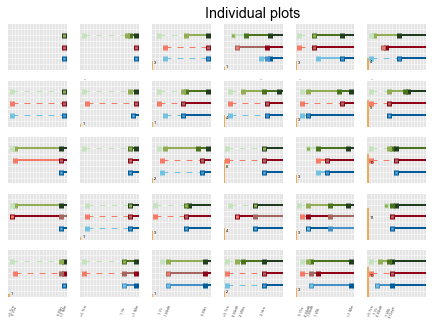

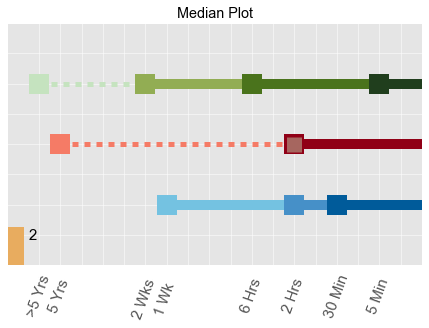

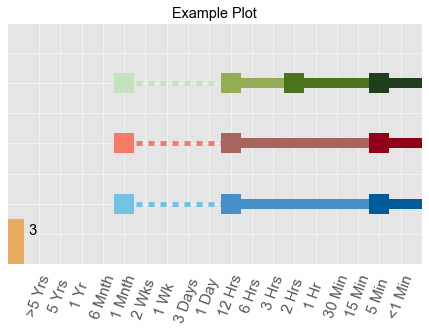

In [24]:
#Huge huge plotting script

GridCols = 6
GridRows = 5

GridRows += 2
#By planning step (put all method together, all place, etc...)
#for planning_steps in ['154','124','123','4','1','12',]:

mpl.rcParams['font.sans-serif']='Arial'


includePrep = True
for planning_steps in ['1']:
    for x2 in range(GridRows):
        for x in range(GridCols):
            if (x == 0 or x == 1 or x == 2 or x == 3 or x == 4) and (x2 == 5 or x2 == 6):
                pass
            else:
                #Set time labels empty and only fill in the ones that are present
                TimeLabels = ['','','','','','','','','','','','','','','','','','']
                #If it's the median plot (==5), make it bigger otherwise make it pretty small
                if (x == 5 and x2 == 5) or (x == 5 and x2 == 6):
                    fig,ax_median=plt.subplots(1)
                    if x2 == 5:
                        plt.title('Median Plot')
                    elif x2 == 6:
                        plt.title('Example Plot')
                    MethodMarkerSizeOrig = 20
                    MethodMarkerEdgeOrig = 20
                    line_width = 10
                else:
                    ax = plt.subplot2grid((GridRows-2,GridCols), (x2, x))
                    MethodMarkerSizeOrig = 5
                    MethodMarkerEdgeOrig = 5
                    line_width = 2
                    if x == 3 and x2 == 0:
                        plt.title('Individual plots')
                #Grab each subject and pull out method, place and thoughts and onset SI for that subject
                SingleSub = GraphVarRev.ix[x2+(5*x)]
                #SingleSubNumPrep = 17-SingleSub.TotalAttemptNumPrep
                SingleSubNumPrep = SingleSub.TotalAttemptNumPrep
                SingleSubMethod = SingleSub.ix[0:3].dropna()
                SingleSubMethod.sort_values(inplace=True)
                SingleSubPlace = SingleSub.ix[3:6].dropna()
                SingleSubPlace.sort_values(inplace=True)
                SingleSubMullDec = SingleSub.ix[[6,7,8,10]].dropna()
                SingleSubMullDec.sort_values(inplace=True)

                #Set the size for this subject. 
                #If two steps occurred at the same time it will shrink the marker size
                #and reset it for the next step or next subject
                MethodMarkerSize = MethodMarkerSizeOrig
                MethodMarkerEdge = MethodMarkerEdgeOrig
                
                pthway_step_list = [SingleSubMethod,SingleSubPlace,SingleSubMullDec]
                #for each step in the list for graphing, set it to in_df and graph it
                for in_df in pthway_step_list:
                    #For each step, set the Y-axis location
                    if 'Meth' in in_df.index[0]:
                        y_loc = 2
                    elif 'Place' in in_df.index[0]:
                        y_loc = 1
                    elif 'ThisAt' in in_df.index[0] or 'Years' in in_df.index[0]:
                        y_loc = 3
                    #For each row within the step (e.g. First thought, ThisAttempt, Sure for method)
                    for i in range(in_df.index.shape[0]):
                        #If person mulled and the mulling was shorter than the decision, move it before decision and label it (this just happened once so it's specificied for that one example)
                        if x==5 and x2 == 6:
                            TimeLabels = TimeLabelAll
                        elif SingleSubMullDec.shape[0] == 4 and in_df.index[i] == 'ThisAt_Mulling123' and SingleSubMullDec.ix['ThisAt_Mulling123'] > SingleSubMullDec.ix['ThisAt_Decision123']:
                            in_df.ix['ThisAt_Mulling123'] = in_df.ix['ThisAt_Decision123']-1
                            TimeLabels[int(in_df.ix[i])] = '2 Hrs +'
                        #elif x2+(5*x) == 26 and in_df.index[i] == 'ThisAt_Mulling123':
                        #	TimeLabels[int(in_df.ix[i])] = '6 Days'
                        else:
                            #Fill in time labels used based on the number-to-label-dictionary
                            TimeLabels[int(in_df.ix[i])] = '%s'%DictTimeLabel[int(in_df.ix[i])]
                        #plot the lines
                        if ('First' in in_df.index[i] or 'Years' in in_df.index[i]) and int(in_df.ix[0])<SingleSubMullDec.ThisAt_ThoughtsStart123:
                            plt.plot(range(int(in_df.ix[i]),19),[y_loc]*(19-int(in_df.ix[i])),'--',linewidth=line_width/2,c=ColorDict[in_df.index[i]])
                        else:
                            plt.plot(range(int(in_df.ix[i]),19),[y_loc]*(19-int(in_df.ix[i])),linewidth=line_width,c=ColorDict[in_df.index[i]])
                    #count backwards (2,1,0) for each step
                    for i in range(in_df.index.shape[0]-1,-1,-1):
                        #if an item within the same step (method, place, thought) 
                        #is the same number as the current, then shrink the box so they are concentric
                        if i<in_df.shape[0]-1 and int(in_df.ix[i]) == int(in_df.ix[i+1]):
                            if x == 5 and x2 == 5:
                                MethodMarkerSize -= 5
                                MethodMarkerEdge -= 5
                            else:
                                MethodMarkerSize -= 2
                                MethodMarkerEdge -= 2
                        else:
                            #otherwise keep the box size the regular size
                            MethodMarkerSize = MethodMarkerSizeOrig
                            MethodMarkerEdge = MethodMarkerEdgeOrig
                        #plot rectangles
                        plt.plot(int(in_df.ix[i]),y_loc,"|",markeredgecolor=ColorDict[in_df.index[i]],markersize=MethodMarkerSize,markeredgewidth = MethodMarkerEdge)

                if SingleSubNumPrep > 0 and includePrep:
                    plt.bar(-1.5,SingleSubNumPrep/4,color='#E8AC5F',edgecolor='None')
                    TextNumPrepLoc = SingleSubNumPrep/6
                    TextNumPrep = str(int(SingleSubNumPrep))
                    if x == 5 and (x2 == 5 or x2 ==6):
                        exec 'plt.text(-.5,TextNumPrepLoc,%s,fontsize = 15)'%TextNumPrep
                    else:
                        exec 'plt.text(-.5,TextNumPrepLoc,%s,fontsize = 4)'%TextNumPrep


                plt.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='on')
                plt.tick_params(axis='y',which='both',left='off',right='off',labelleft='off')
                plt.axis([-1.5,18,0,4])
                plt.xticks(range(len(TimeLabels)))
                if x == 5 and (x2 == 5 or x2 == 6):
                    ax_median.set_xticklabels(TimeLabels,fontsize=15,rotation=70)
                    plt.gcf().subplots_adjust(bottom=0.14)
                    plt.gcf().subplots_adjust(left=0.02)
                    plt.gcf().subplots_adjust(right=0.98)
                    plt.gcf().subplots_adjust(top=0.98)

                else:
                    ax.set_xticklabels(TimeLabels,fontsize=4,rotation=70)

                    plt.gcf().subplots_adjust(bottom=0.03)
                    plt.gcf().subplots_adjust(left=0.01)
                    plt.gcf().subplots_adjust(right=0.98)
                    plt.gcf().subplots_adjust(top=0.98)
    #exec 'plt.savefig(\'FinalGraphTimePtMedian.png\',dpi=300)'
    

## Histograms

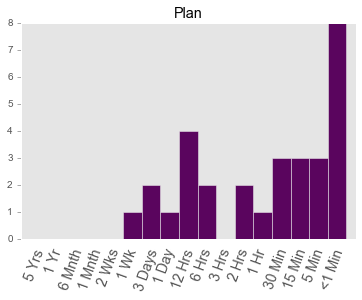

In [25]:

GraphVarRev_noMedian = GraphVarRev.drop([30,31],axis=0)

#GraphVarRev_noMedian.columns = ['First Thought of Suicide Method (Lifetime)','First Thought of Suicide Method (For Current Attempt)','Sure of Suicide Method Would Use','First Thought of Place to Attempt Suicide (Lifetime)','First Thought of Place to Attempt Suicide (For Current Attempt)','Sure of Place to Attempt Suicide','Onset of Suicide Ideation (For Current Attempt)','Mulled Over the Decision to Attempt','Decision to Attempt','Total Number of Preparatory Actions','Onset of Suicidal Ideation (Lifetime)']

GraphVarRev_noMedian.columns = ['Method (Lifetime)','Method (Current Attempt)','Sure of Method','Place (Lifetime)','Place (Current Attempt)','Sure of Place','Ideation (Current Attempt)','Mulling Over Decision','Decision (Current Attempt)','Preparatory Actions (Current Attempt)','Ideation (Lifetime)']

TimeLabels2 = ['>5 Yrs','5 Yrs','1 Yr','6 Mnth','1 Mnth','2 Wks','1 Wk','3 Days','1 Day','12 Hrs','6 Hrs','3 Hrs','2 Hrs','1 Hr','30 Min','15 Min','5 Min','<1 Min']

#GraphVarRev_noMedianColorDict = {'First Thought of Suicide Method (Lifetime)':'#F57B66','First Thought of Suicide Method (For Current Attempt)':'#A6665F','Sure of Suicide Method Would Use':'#900016','First Thought of Place to Attempt Suicide (Lifetime)':'#74C2E1','First Thought of Place to Attempt Suicide (For Current Attempt)':'#4690C8','Sure of Place to Attempt Suicide':'#005B9A','Onset of Suicide Ideation (For Current Attempt)':'#92AD53','Mulled Over the Decision to Attempt':'#4A731C','Decision to Attempt':'#203E1D','Total Number of Preparatory Actions':'#E8AC5F','Onset of Suicidal Ideation (Lifetime)':'#C5E3BF'}
GraphVarRev_noMedianColorDict = {'Method (Lifetime)':'#F57B66','Method (Current Attempt)':'#A6665F','Sure of Method':'#900016','Place (Lifetime)':'#74C2E1','Place (Current Attempt)':'#4690C8','Sure of Place':'#005B9A','Ideation (Current Attempt)':'#92AD53','Mulling Over Decision':'#4A731C','Decision (Current Attempt)':'#203E1D','Preparatory Actions (Current Attempt)':'#E8AC5F','Ideation (Lifetime)':'#C5E3BF'}


#pth = '/Users/alexmillner/Dropbox/ValiditySingleOutcomeMeasurement/Project2/Drafts/Histograms'
#os.chdir(pth)		

Plan = pd.Series(index = GraphVarRev_noMedian.index)

Min_Plan = GraphVarRev_noMedian[['Ideation (Current Attempt)','Method (Current Attempt)','Place (Current Attempt)','Sure of Method','Sure of Place']].max(axis=1)

Plan_plot = Min_Plan.groupby(Min_Plan).count().reindex(index=range(18)).fillna(value=0)

fig,ax=plt.subplots(1)
#Plan_plot.plot(ax=ax,kind='bar',width = 1,grid=False,color='#005B9A')
Plan_plot.plot(ax=ax,kind='bar',width = 1,grid=False,color='#5A055E')
plt.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='on')
plt.tick_params(axis='y',which='both',left='on',right='off',labelleft='on')
plt.xticks(np.arange(len(TimeLabels2))-.25)
ax.set_xticklabels(TimeLabels2,fontsize=14,rotation=70)
plt.axis([0,18,0,8])
plt.gcf().subplots_adjust(bottom=0.15)
plt.title('Plan')
#plt.savefig('Minimum_ThoughtMthdPlaceSure_ThisAt600.png',dpi=600)


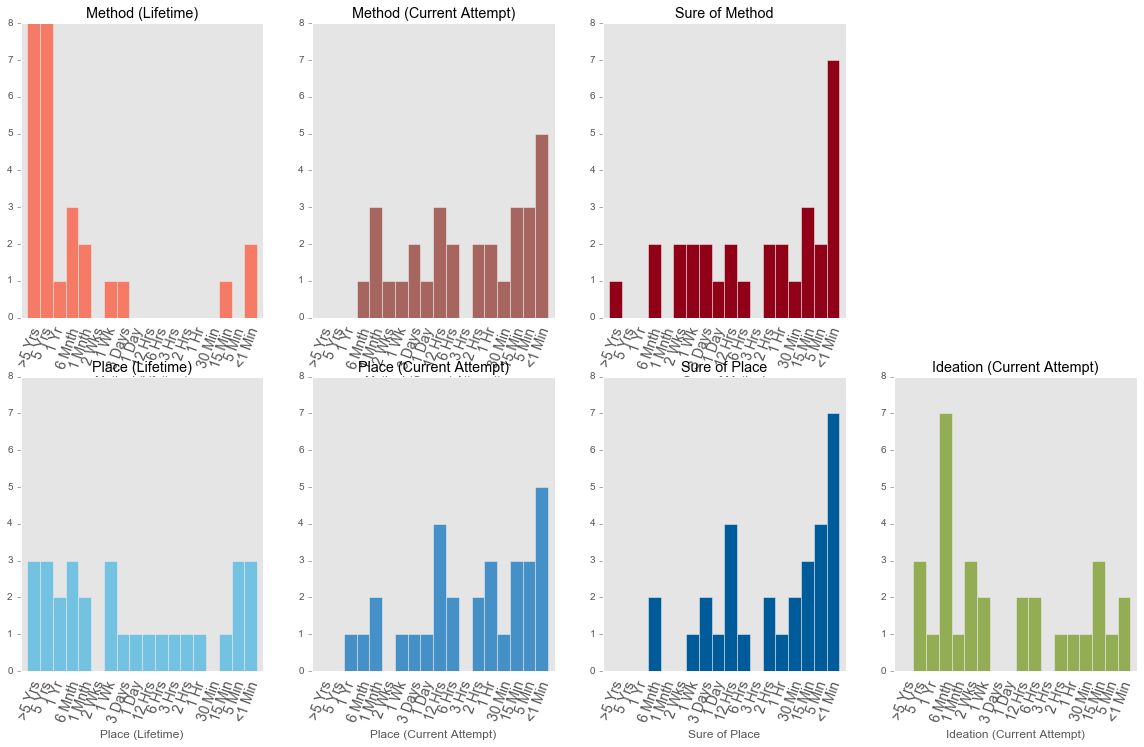

In [26]:
Step_plot = Plan.groupby(Plan).count().reindex(index=range(18)).fillna(value=0)
GridCols = 4
GridRows = 2
fig = plt.figure(figsize=(20, 10)) 
for grows,gcols,cols in zip([0,0,0,1,1,1,1],[0,1,2,0,1,2,3],GraphVarRev_noMedian.columns):
    ax = plt.subplot2grid((GridRows,GridCols), (grows, gcols))
    Step_plot = GraphVarRev_noMedian[cols].groupby(GraphVarRev_noMedian[cols]).count().reindex(index=range(18)).fillna(value=0)
    Barcolor = GraphVarRev_noMedianColorDict[cols]
    Step_plot.plot(ax=ax,kind='bar',width = 1,grid=False,color=Barcolor)
    plt.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='on')
    plt.tick_params(axis='y',which='both',left='on',right='off',labelleft='on')

    if cols == 'Preparatory Actions (Current Attempt)':
        plt.axis([-1, 12, 0, 8])
        plt.xticks(np.arange(13))
        ax.set_xticklabels(range(12),fontsize=14)

    else:
        if cols == 'Decision (Current Attempt)':
            plt.axis([-1, 18, 0, 14])
        else:
            plt.axis([-1, 18, 0, 8])
        plt.xticks(np.arange(len(TimeLabels2))-.25)
        ax.set_xticklabels(TimeLabels2,fontsize=14,rotation=70)
        plt.gcf().subplots_adjust(bottom=0.05,top=.95)


    plt.title(GraphVarRev_noMedian[cols].name)
    #exec 'plt.savefig(\'%s.png\',dpi=300)'%cols

## Order of pathway steps

In [27]:
import operator as op
import pandas as pd
import numpy as np

GraphVarRev_Orig31=GraphVarRev.copy(deep=True)
GraphVarRev=GraphVarRev.drop([30,31],axis=0)

def ComparePathwaySteps(InCols,numCmprs):

	#InCols = A list of lists of columns to compare. Lists are either 2 or 3 columns
	#numCmprs = Is the list lists of 2 columns (aka 1 comparison) or 3 columns (aka 2 comparisons)
	#if 2 comparisons, do you want to compare columns 2 and 3 with column 1 (that would be 20 - 2 for 2 comparisons and 0 for compare both with column zero)
	#or compare column 1 and 3 with column 2, (that would be 21 for 2 comparisons and 1 for compare both with column 1 )

	import operator as op
	import pandas as pd
	import numpy as np
	ops = {"gt":op.gt, "lt":op.lt,"eq":op.eq}

	OrderCompareNumAll = pd.DataFrame()
	OrderCompareIndexAll = pd.DataFrame()

	for cols in InCols:
		newrow = 0
		if numCmprs == 1:
			column_name = cols[0][:-3]+"_"+"v"+"_"+cols[1][:-3]
		elif numCmprs == 20 or numCmprs == 21:
			column_name = cols[0][:-3]+"_"+"v"+"_"+cols[1][:-3]+"_"+"v"+"_"+cols[2][:-3]
		OrderCompareNum = pd.DataFrame(columns = [column_name],index = ['a','b','c'])
		OrderCompareIndex = pd.DataFrame(columns = [column_name],index = ['a','b','c'])
		for cmpr in ["gt","lt","eq"]:
			op_s = ops[cmpr]
			if numCmprs == 1:
				PostCmprIndex = GraphVarRev.index[op_s(GraphVarRev[cols[0]],GraphVarRev[cols[1]])]
			elif numCmprs == 21:
				PostCmprIndex = GraphVarRev.index[op_s(GraphVarRev[cols[0]],GraphVarRev[cols[1]])&op_s(GraphVarRev[cols[1]],GraphVarRev[cols[2]])]
			elif numCmprs == 20:
				PostCmprIndex = GraphVarRev.index[op_s(GraphVarRev[cols[0]],GraphVarRev[cols[1]])&op_s(GraphVarRev[cols[0]],GraphVarRev[cols[2]])]

			OrderCompareNum[column_name].ix[newrow] = len(PostCmprIndex)
			OrderCompareNum.index.values[newrow] = cmpr
			if OrderCompareNum[column_name].ix[newrow] == 0:
				OrderCompareIndex[column_name].ix[newrow] = np.nan
			else:
				OrderCompareIndex[column_name].ix[newrow] = list(PostCmprIndex.values)
			OrderCompareIndex.index.values[newrow] = cmpr
			newrow +=1
		OrderCompareNumAll = pd.concat([OrderCompareNumAll,OrderCompareNum],axis=1)
		OrderCompareIndexAll = pd.concat([OrderCompareIndexAll,OrderCompareIndex],axis=1)


	return(OrderCompareNumAll,OrderCompareIndexAll)


InCols_1cmpr = [\
['FirstTh_Method154', 'ThisAt_Method154'],\
['FirstTh_Method154', 'Sure_Method154'],\
['FirstTh_Method154', 'FirstTh_Place124'],\
['FirstTh_Method154', 'ThisAt_Place124'],\
['FirstTh_Method154', 'Sure_Place124'],\
['FirstTh_Method154', 'ThisAt_ThoughtsStart123'],\
['FirstTh_Method154', 'ThisAt_Mulling123'],\
['FirstTh_Method154', 'ThisAt_Decision123'],\

['ThisAt_Method154', 'Sure_Method154'],\
['ThisAt_Method154', 'FirstTh_Place124'],\
['ThisAt_Method154', 'ThisAt_Place124'],\
['ThisAt_Method154', 'Sure_Place124'],\
['ThisAt_Method154', 'ThisAt_ThoughtsStart123'],\
['ThisAt_Method154', 'ThisAt_Mulling123'],\
['ThisAt_Method154', 'ThisAt_Decision123'],\

['Sure_Method154', 'FirstTh_Place124'],\
['Sure_Method154', 'ThisAt_Place124'],\
['Sure_Method154', 'Sure_Place124'],\
['Sure_Method154', 'ThisAt_ThoughtsStart123'],\
['Sure_Method154', 'ThisAt_Mulling123'],\
['Sure_Method154', 'ThisAt_Decision123'],\

['FirstTh_Place124', 'ThisAt_Place124'],\
['FirstTh_Place124', 'Sure_Place124'],\
['FirstTh_Place124', 'ThisAt_ThoughtsStart123'],\
['FirstTh_Place124', 'ThisAt_Mulling123'],\
['FirstTh_Place124', 'ThisAt_Decision123'],\

['ThisAt_Place124', 'Sure_Place124'],\
['ThisAt_Place124', 'ThisAt_ThoughtsStart123'],\
['ThisAt_Place124', 'ThisAt_Mulling123'],\
['ThisAt_Place124', 'ThisAt_Decision123'],\

['Sure_Place124', 'ThisAt_ThoughtsStart123'],\
['Sure_Place124', 'ThisAt_Mulling123'],\
['Sure_Place124', 'ThisAt_Decision123'],\

['ThisAt_ThoughtsStart123', 'ThisAt_Mulling123'],\
['ThisAt_ThoughtsStart123', 'ThisAt_Decision123'],\
['ThisAt_Mulling123', 'ThisAt_Decision123'],\
]

[OrderCompareNumAll_1compr,OrderCompareIndexAll_1compr] = ComparePathwaySteps(InCols_1cmpr,1)





In [28]:
OrderCompareIndexAll_1compr['ThisAt_Method_v_ThisAt_ThoughtsStart']

gt    [2, 3, 5, 6, 10, 12, 15, 16, 19, 21, 22, 23, 2...
lt                                                  NaN
eq       [0, 1, 4, 7, 8, 9, 11, 13, 14, 17, 18, 20, 26]
Name: ThisAt_Method_v_ThisAt_ThoughtsStart, dtype: object

## Curve fitting time estimates

In [29]:
pthwy_melt = D_pthwy_inSecs.copy(deep=True)
pthwy_melt = pthwy_melt.reset_index()
pthwy_melt = pd.melt(pthwy_melt,id_vars = 'index',value_vars = pthwy_melt.columns[1:].tolist())
pthwy_melt = pthwy_melt.value.sort_values().reset_index(drop=True)
pthwy_melt = pthwy_melt.dropna()

In [30]:
onemin = 60
fivemin = 60*5
thirtymin = 60*30
hour = 60*60
day = hour*24+10
twodays = hour*48
fiftyfour_hours = hour*54
week = day*7
month = day*30
six_months = week*26
year = 365*day
three_years = year*3
six_years = year*6
all_d = np.inf

### Time estimation plots

##### 1 minute

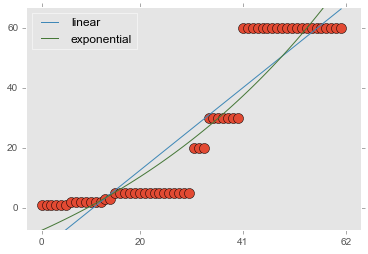

In [31]:
y = pthwy_melt[pthwy_melt<=60].dropna()
x = pthwy_melt[pthwy_melt<=60].dropna().index
plot_exp_lin_(y,x,yticksval=[0,20,40,60])

##### 5 minutes

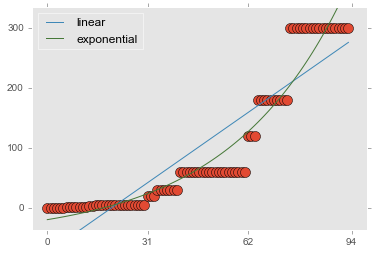

In [32]:
y = pthwy_melt[pthwy_melt<=5*60].dropna()
x = pthwy_melt[pthwy_melt<=5*60].dropna().index
plot_exp_lin_(y,x,[0,5*20,5*40,5*60])

#### 30 minutes

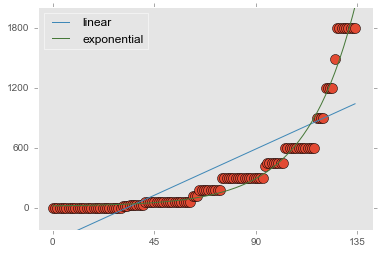

In [33]:
y = pthwy_melt[pthwy_melt<=thirtymin].dropna()
x = pthwy_melt[pthwy_melt<=thirtymin].dropna().index
plot_exp_lin_(y,x,[0,30*20,30*40,30*60])

#### 1 hour

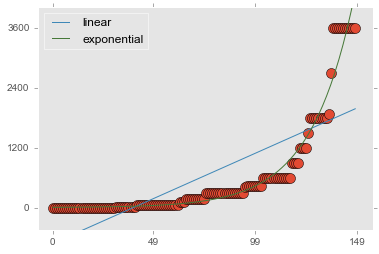

In [34]:
y = pthwy_melt[pthwy_melt<=hour].dropna()
x = pthwy_melt[pthwy_melt<=hour].dropna().index
plot_exp_lin_(y,x,[0,hour*1/3,hour*2/3,hour])

#### 1 day

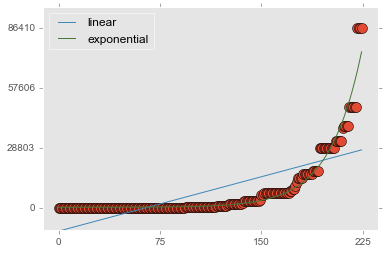

In [35]:
y = pthwy_melt[pthwy_melt<=day].dropna()
x = pthwy_melt[pthwy_melt<=day].dropna().index
plot_exp_lin_(y,x,[0,day*1/3,day*2/3,day])

#### 1 week

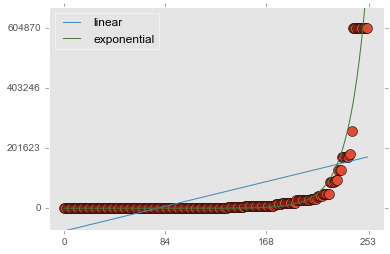

In [36]:
y = pthwy_melt[pthwy_melt<=day*7].dropna()
x = pthwy_melt[pthwy_melt<=day*7].dropna().index
plot_exp_lin_(y,x,[0,day*7*1/3,day*7*2/3,day*7])

##### 1 month

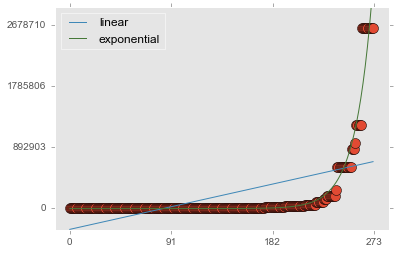

In [37]:
y = pthwy_melt[pthwy_melt<=day*31].dropna()
x = pthwy_melt[pthwy_melt<=day*31].dropna().index
plot_exp_lin_(y,x,[0,day*31*1/3,day*31*2/3,day*31])

##### 6 months

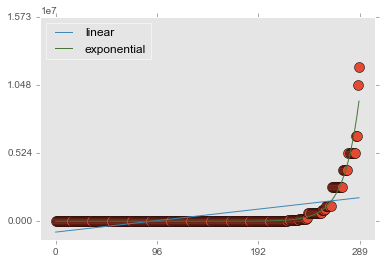

In [38]:
y = pthwy_melt[pthwy_melt<=six_months].dropna()
x = pthwy_melt[pthwy_melt<=six_months].dropna().index
plot_exp_lin_(y,x,[0,six_months*1/3,six_months*2/3,six_months])

##### 1 year

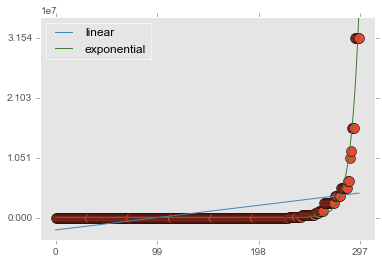

In [39]:
y = pthwy_melt[pthwy_melt<=year].dropna()
x = pthwy_melt[pthwy_melt<=year].dropna().index
plot_exp_lin_(y,x,[0,year*1/3,year*2/3,year])

#### 3 years

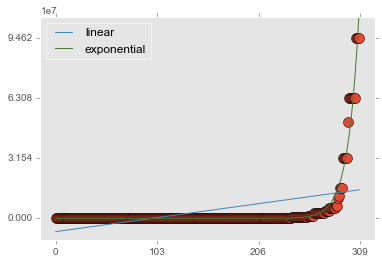

In [40]:
y = pthwy_melt[pthwy_melt<=three_years].dropna()
x = pthwy_melt[pthwy_melt<=three_years].dropna().index
plot_exp_lin_(y,x,[0,three_years*1/3,three_years*2/3,three_years])

#### All data

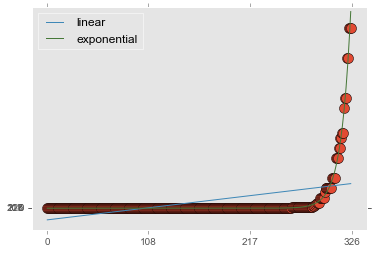

In [41]:
a = pthwy_melt.shape[0]
y = pthwy_melt[pthwy_melt<=all_d].dropna()
x = pthwy_melt[pthwy_melt<=all_d].dropna().index
plot_exp_lin_(y,x,[0,a*1/3,a*2/3,a])

##### Let's look at some non-prototypical time points

##### 5 hours 15 minutes

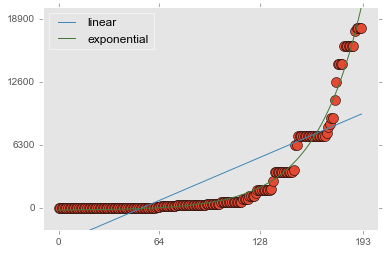

In [42]:
hrs5_min15 = (60*60*5)+(60*15)
y = pthwy_melt[pthwy_melt<=hrs5_min15].dropna()
x = pthwy_melt[pthwy_melt<=hrs5_min15].dropna().index
plot_exp_lin_(y,x,[0,hrs5_min15*1/3,hrs5_min15*2/3,hrs5_min15])

##### 4 days, 10 hours, 20 min 30 seconds

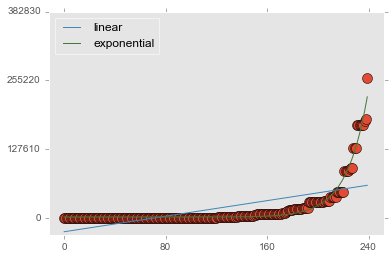

In [43]:
days4_hrs10_20min_sec30 = (60*60*24*4)+(60*60*10)+(60*20)+30
y = pthwy_melt[pthwy_melt<=days4_hrs10_20min_sec30].dropna()
x = pthwy_melt[pthwy_melt<=days4_hrs10_20min_sec30].dropna().index
plot_exp_lin_(y,x,[0,days4_hrs10_20min_sec30*1/3,days4_hrs10_20min_sec30*2/3,days4_hrs10_20min_sec30])

##### 2 months 17 days, 6 hours, 33 min 42 sec

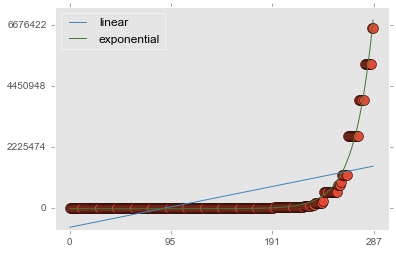

In [44]:
mnths2_days17_hrs6_33min_42 = (60*60*24*60)+(60*60*24*17)+(60*60*6)+(60*33)+42
y = pthwy_melt[pthwy_melt<=mnths2_days17_hrs6_33min_42].dropna()
x = pthwy_melt[pthwy_melt<=mnths2_days17_hrs6_33min_42].dropna().index
plot_exp_lin_(y,x,[0,mnths2_days17_hrs6_33min_42*1/3,mnths2_days17_hrs6_33min_42*2/3,mnths2_days17_hrs6_33min_42])

### Exp fit vs  linear - BIC

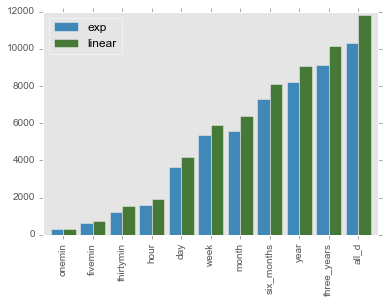

In [45]:
time_list = [onemin,fivemin,thirtymin,hour,day,week,month,six_months,year,three_years,all_d]
time_list_str = ['onemin','fivemin','thirtymin','hour','day','week','month','six_months','year','three_years','all_d']


bic_output = pd.DataFrame([],columns=['exp','linear'],index = time_list_str)
for t,t_str in zip(time_list,time_list_str):
    pthwy_melt_t = pthwy_melt[pthwy_melt<=t]
    y = (pthwy_melt_t)
    x = pd.DataFrame(pthwy_melt_t).index
    popt_exp, pcov_exp = curve_fit(func_exp, x, y,p0=(1, 1e-6, 1))
    popt_lin, pcov_lin = curve_fit(func_linear, x, y)
    
    bic_exp,chi_exp = printBIC(popt_exp,mod='exp')
    bic_lin,chi_lin = printBIC(popt_lin,mod='linear')
    bic_output.loc[t_str,'exp'] = bic_exp
    bic_output.loc[t_str,'linear'] = bic_lin
    
    
    
bic_output.plot(kind='bar',grid=False,color=['#3F88B7','#467838'],width=.85)
#plt.savefig('BIC_barpotv2',dpi=600)

### Bins

In [46]:
bins=pd.DataFrame([0,60,300,900,1800,3600,7200,10800,21600,43200,86400,259200,604800,1210000,2630000,15780000,31540000],columns=['bins'])

In [47]:
y = bins.bins
x = bins.index

(-50000, 600000)

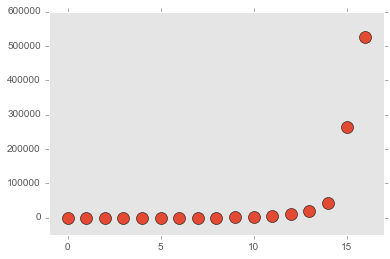

In [48]:
pd.DataFrame(bins/60.0).plot(style='o',legend=False,grid=False,markersize=12)
pylab.xlim([-1,17])
pylab.ylim([-50000,600000])
#plt.savefig('BINS',dpi=600)

### Fitting data to bins

In [49]:
bins_melt = GraphVar.iloc[:,0:12].reset_index()
bins_melt.drop(['TotalAttemptNumPrep'],axis=1,inplace=True)
bins_melt = pd.melt(bins_melt,id_vars ='index',value_vars = bins_melt.columns.tolist()[1:])
bins_melt = bins_melt.value.sort_values().reset_index(drop=True).dropna()

(-10, 335)

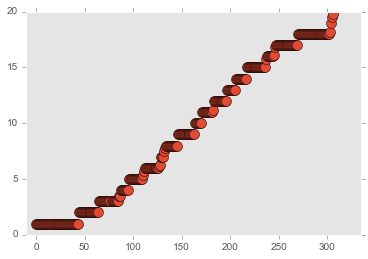

In [50]:
bins_melt.drop([77],inplace=True)
bins_melt.add(1).dropna().plot(linewidth=3,style='o',markersize=10)
plt.grid(b=None)
pylab.ylim([0,20])
pylab.xlim([-10,335])
#plt.savefig('all_resp_fitbinsV2.png',dpi=600)

#### All data log transformed

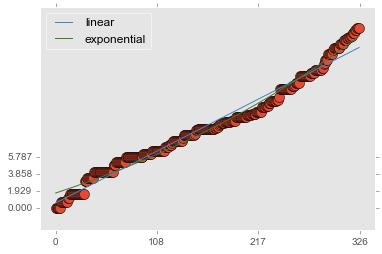

In [51]:
a = np.log(pthwy_melt.shape[0])
y = np.log(pthwy_melt[pthwy_melt<=all_d].dropna())
x = np.log(pthwy_melt[pthwy_melt<=all_d].dropna()).index
plot_exp_lin_(y,x,[0,a*1/3,a*2/3,a],pltfilename='Log all data')

## Survival Curves

In [52]:
kmf = KaplanMeierFitter()

In [53]:
pthwy = D_pthwy_inSecs.copy(deep=True)
pthwy.drop(['Attempt_FirstTime_ThoughtofMethodforThisAttemptTimeValue2','Attempt_TimeDecisionTimeValue',\
            'Attempt_WhenDecisionTimeValue',\
            'Attempt_Travel_HowLongTimeValue','Attempt_Dec2Act_TimeUnitTimeValue'],axis=1,inplace=True)

In [55]:
pthwy.columns=['Method(Lifetime) in secs','Method(Current Attempt)','Sure of Method',\
               'Place(Lifetime) in secs','Place (Current Attempt)','Sure of Place',\
               'Ideation(Current Attempt)','Mulling','Decision']
p=pthwy.copy(deep=True)

In [56]:
fortyeight_hours = 48*60*60
twentyfour_hours = 24*60*60
three_hours = 3*60*60


In [57]:
print '3 hours = {} seconds'.format(three_hours ) 
print '3 hours log transformed = {:1.2}'.format(np.log(three_hours)) 

3 hours = 10800 seconds
3 hours log transformed = 9.3


##### 3 hours (left censor)

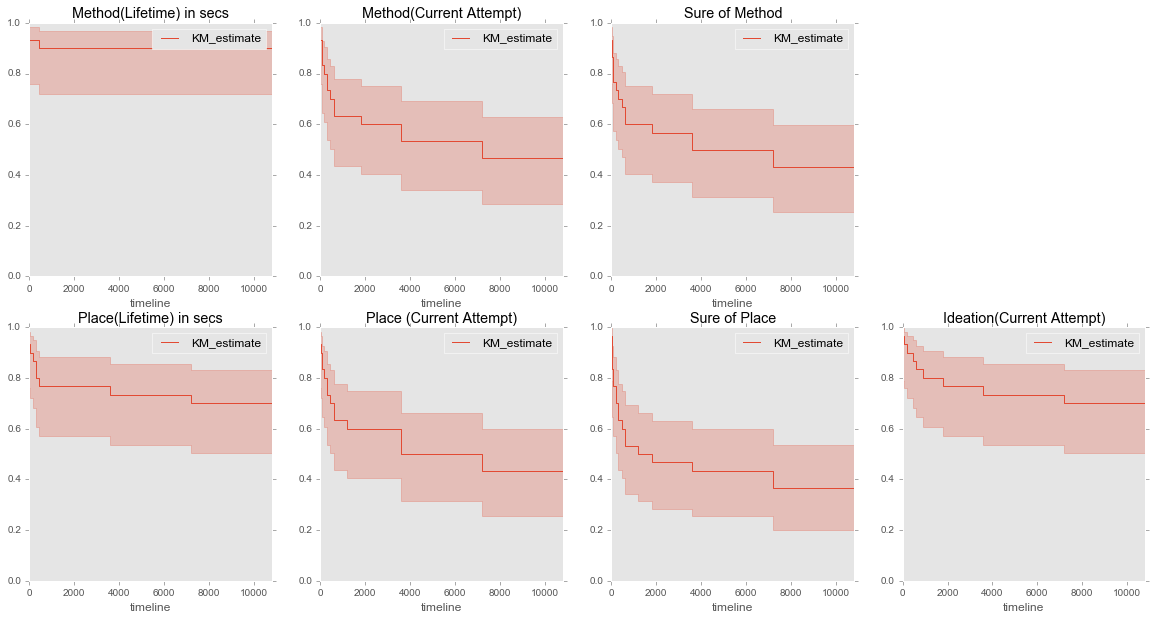

In [58]:
p3=p.copy(deep=True)
for col in p.columns:
    p3[col] = p[col].apply(lambda x: x if x <= 60*60*3 else 60*60*3)
plot_survival(p3,vert_line=three_hours)

##### 6 hours (left censor)

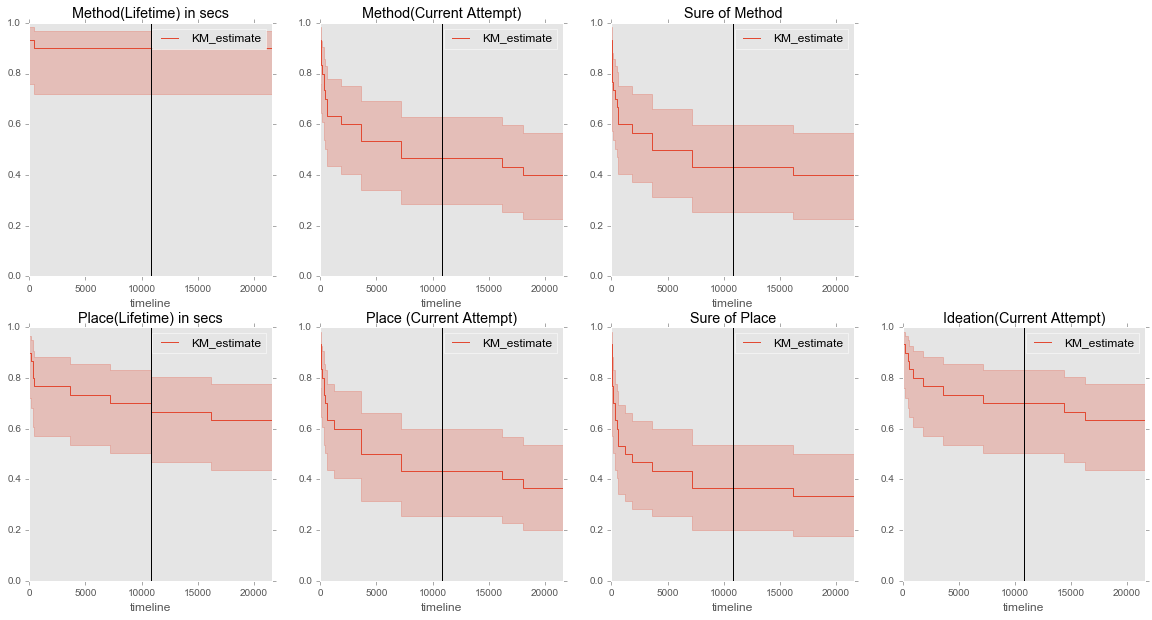

In [59]:
p6=p.copy(deep=True)
for col in p.columns:
    p6[col] = p[col].apply(lambda x: x if x <= 60*60*6 else 60*60*6)
plot_survival(p6,vert_line=three_hours)

##### 12 hours (left censor)

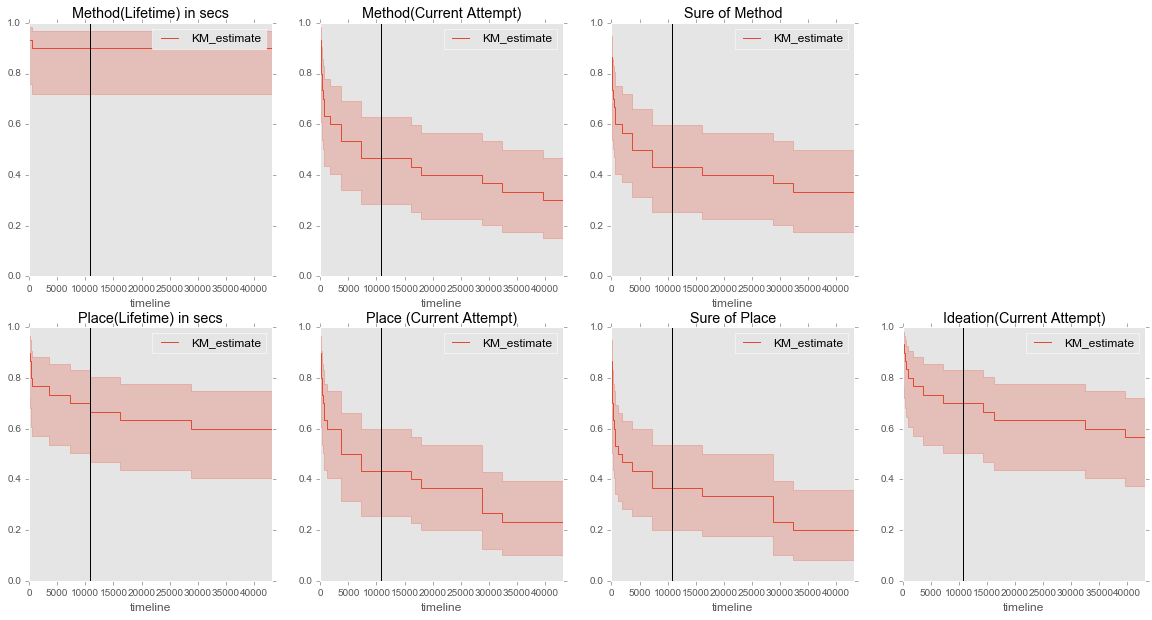

In [60]:
p12=p.copy(deep=True)
for col in p.columns:
    p12[col] = p[col].apply(lambda x: x if x <= 60*60*12 else 60*60*12)
plot_survival(p12,vert_line=three_hours)

##### 24 hours (left censor)

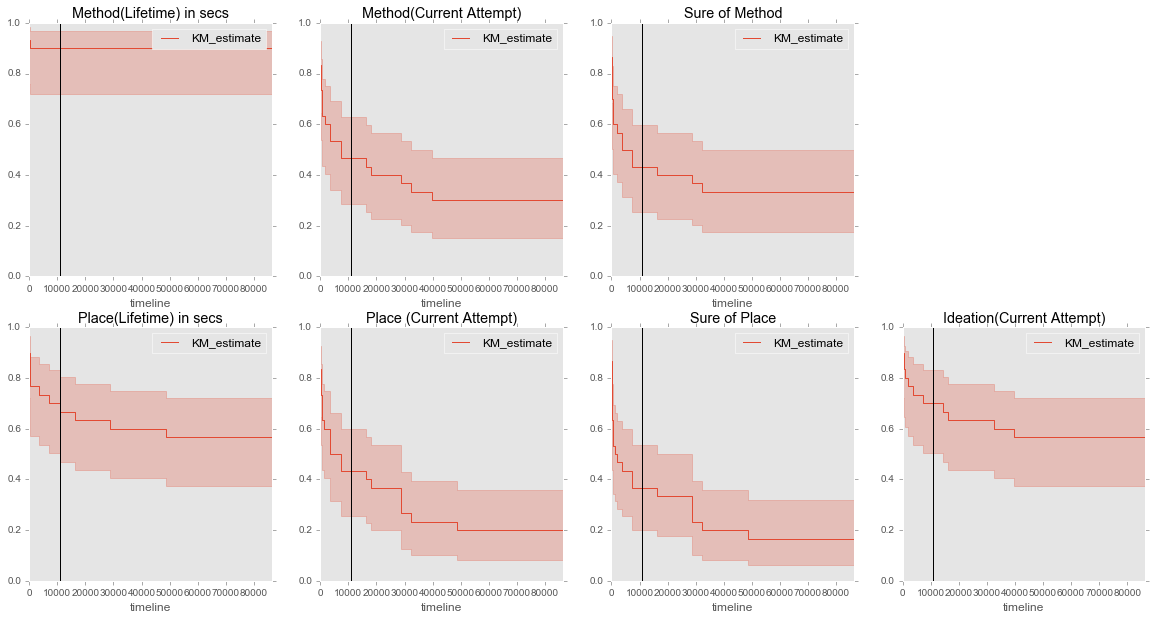

In [61]:
p24=p.copy(deep=True)
for col in p.columns:
    p24[col] = p[col].apply(lambda x: x if x <= 60*60*24+10 else 60*60*24+10)
plot_survival(p24,vert_line=three_hours)

##### 48 hours (left censored)

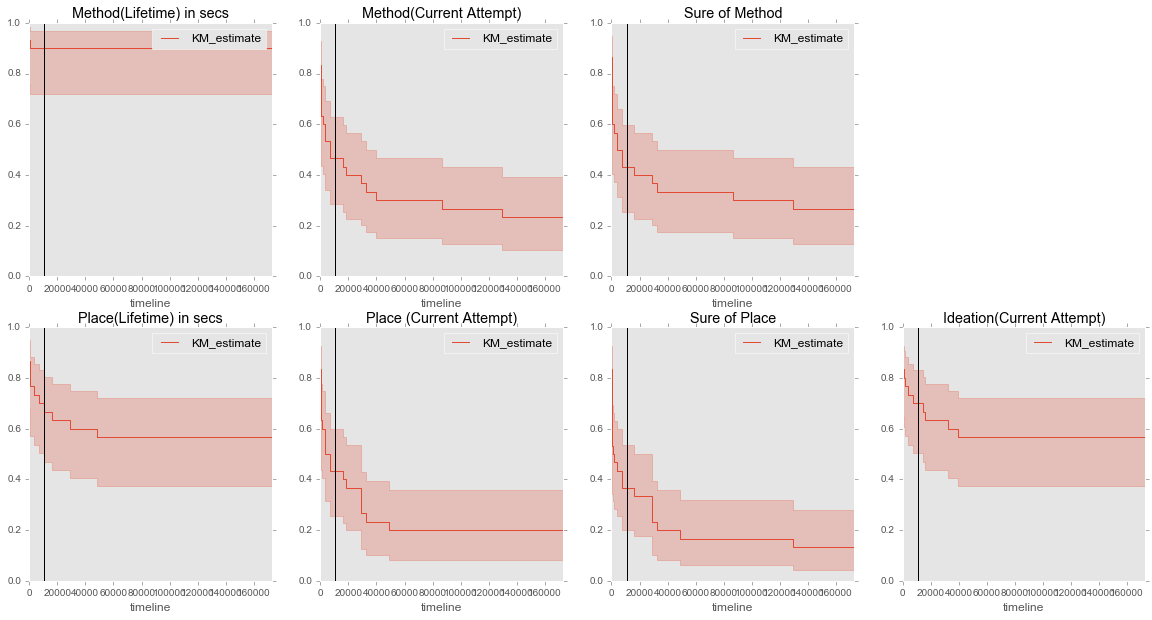

In [62]:
p48=p.copy(deep=True)
for col in p.columns:
    p48[col] = p[col].apply(lambda x: x if x <= 60*60*48+10 else 60*60*48+10)
plot_survival(p48,vert_line=three_hours)

##### 72 hours (left censored)

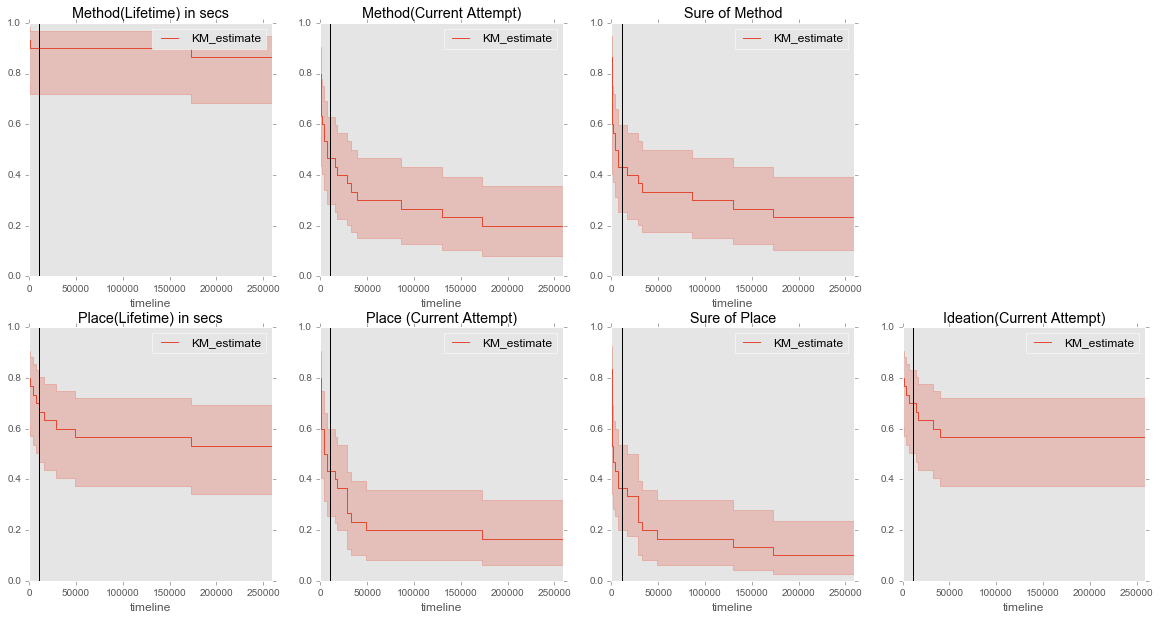

In [63]:
p72=p.copy(deep=True)
for col in p.columns:
    p72[col] = p[col].apply(lambda x: x if x <= 60*60*72+10 else 60*60*72+10)
plot_survival(p72,vert_line=three_hours)

#### Log transformed surivival curves

##### 6 hours

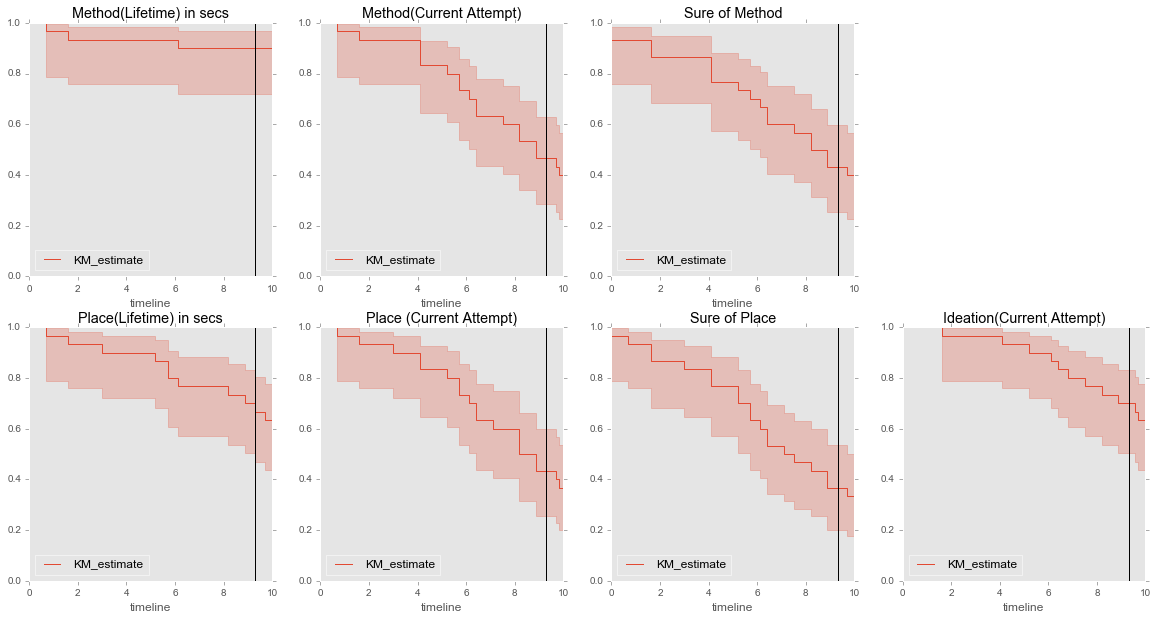

In [64]:
plot_survival(np.log(p6),vert_line=9.3)

##### 12 hours

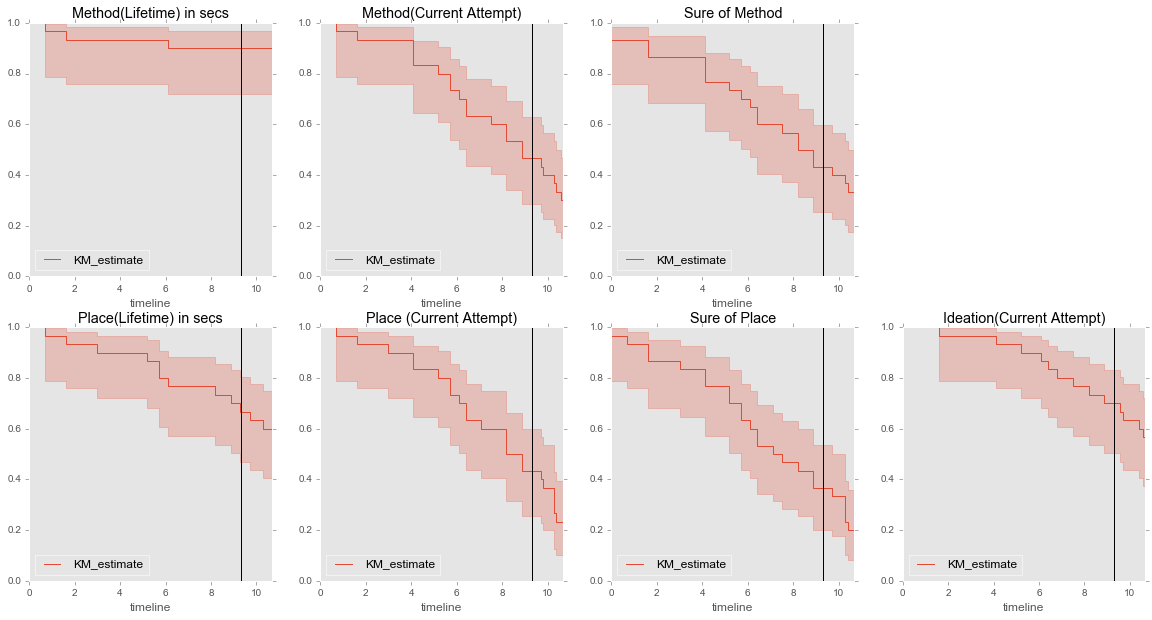

In [65]:
plot_survival(np.log(p12),vert_line=9.3)

##### 24 hours

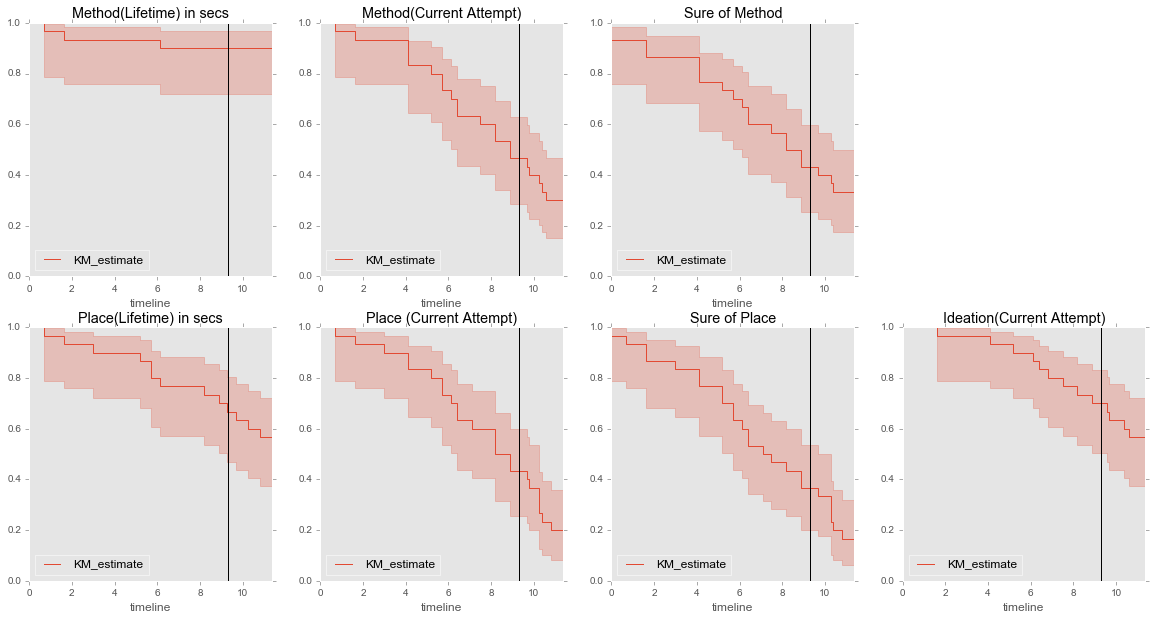

In [66]:
plot_survival(p24,vert_line=9.3,log=True)

##### 48 hours

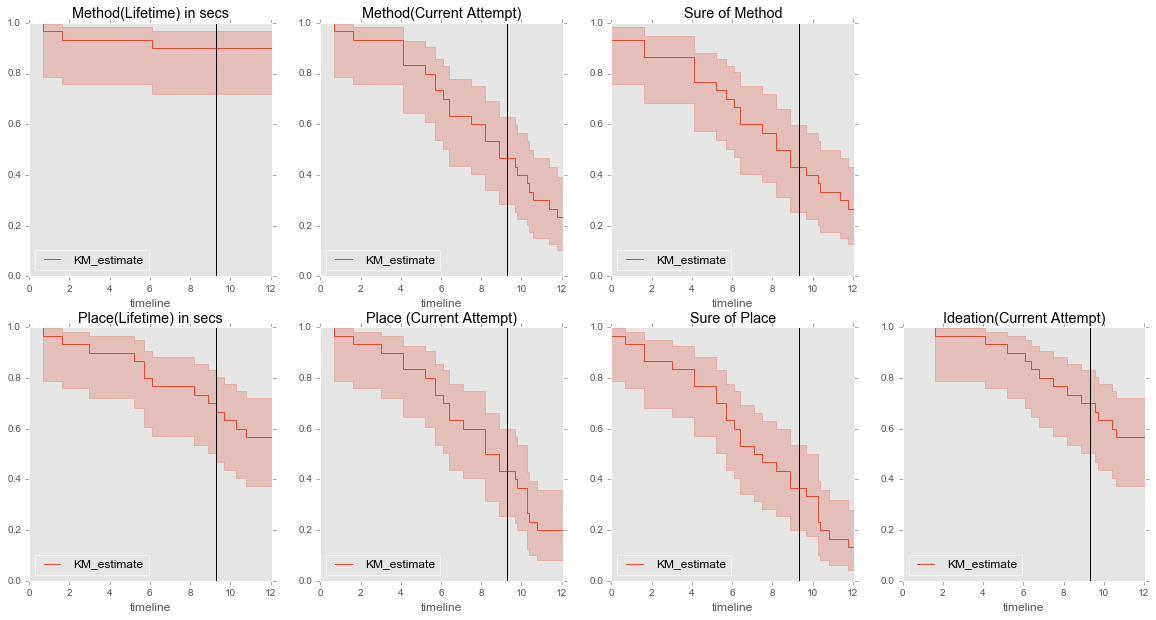

In [67]:
plot_survival(p48,vert_line=9.3,log=True)